Estimate a probe for syllable edit distance on a learned integrator representation.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [65]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm, trange

from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [5]:
model_dir = "outputs/models/w2v2_8/syllable"
# equiv_dataset_path = "data/timit_equiv_phoneme_within_word_prefix_1.pkl"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_syllables.pkl"

metric = "cosine"

In [6]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [8]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)

# # DEV: retain just the samples available in this subset
# spans = [[(start, end) for start, end in spans_i if end < equiv_dataset.hidden_state_dataset.num_frames]
#          for spans_i in state_space_spec.target_frame_spans]
# retain_idxs = [idx for idx, spans_i in enumerate(spans) if len(spans_i) > 0]
# state_space_spec = replace(state_space_spec,
#                            target_frame_spans=[spans[i] for i in retain_idxs],
#                            labels=[state_space_spec.labels[i] for i in retain_idxs],
#                            total_num_frames=equiv_dataset.hidden_state_dataset.num_frames)
    
assert state_space_spec.is_compatible_with(equiv_dataset)

In [9]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

out/embedding_cache/outputs-models-w2v2_8-syllable-data-timit_equiv_phoneme_6_1.pkl.npy


In [10]:
# Retain only syllables with N or more instances
retain_n = 5
retain_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) >= retain_n]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [11]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [41]:
final_frames = [traj_i[np.arange(len(traj_i)), length_i - 1] for traj_i, length_i in zip(trajectory, lengths)]

## Compute syllable edit distance

In [13]:
syllables = state_space_spec.labels

In [14]:
# Function to calculate edit distance between two sequences of phonemes
def edit_distance(s1, s2):
    # Using Wagner-Fischer algorithm for computing edit distance
    m, n = len(s1), len(s2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j   # Deletion
            elif j == 0:
                dp[i][j] = i   # Insertion
            else:
                cost = 0 if s1[i - 1] == s2[j - 1] else 1
                dp[i][j] = min(dp[i - 1][j] + 1,      # Deletion
                               dp[i][j - 1] + 1,      # Insertion
                               dp[i - 1][j - 1] + cost) # Substitution
    return dp[m][n]

In [15]:
distances = np.zeros((len(syllables), len(syllables)))
syllable2idx = {s: i for i, s in enumerate(syllables)}
for i, s1 in enumerate(syllables):
    for j, s2 in enumerate(syllables):
        distances[i, j] = edit_distance(s1, s2)

In [16]:
distances.shape

(1626, 1626)

## Prepare regression analysis

In [42]:
# Scale all vectors by unit norm
final_frames = [f / np.linalg.norm(f, axis=1, keepdims=True) for f in final_frames]

In [56]:
Xs, y = [], []
max_num_pairs, max_num_samples = 100000, 50

syllable_pairs = list(itertools.combinations(list(range(len(syllables))), 2))
np.random.shuffle(syllable_pairs)
print(f"Retain {max_num_pairs} pairs ({100 * max_num_pairs / len(syllable_pairs):.2f}% of all)")
syllable_pairs = syllable_pairs[:max_num_pairs]

for s1, s2 in tqdm(syllable_pairs):
    frame_pairs = list(itertools.product(list(range(len(final_frames[s1]))), list(range(len(final_frames[s2])))))
    np.random.shuffle(frame_pairs)
    frame_pairs = frame_pairs[:max_num_samples]
                       
    for f1, f2 in frame_pairs:
        Xs.append(np.concatenate([final_frames[s1][f1], final_frames[s2][f2]]))
        y.append(distances[s1, s2])

X = np.stack(Xs)
y = np.array(y).astype(float)

Retain 100000 pairs (7.57% of all)


  0%|          | 0/100000 [00:00<?, ?it/s]

In [57]:
X.shape

(4834440, 16)

In [79]:
# Estimate a bilinear map between X pairs and the y edit distance using torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class BilinearMap(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.W = nn.Parameter(torch.randn(input_dim, input_dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, X1, X2):
        return (X1 @ self.W @ X2.T).diagonal() + self.b

        # A = self.W @ self.W
        # return ((X1 - X2) @ A @ (X1 - X2).T).diagonal() + self.b
    
class BilinearMapModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.bilinear = BilinearMap(input_dim)
        
    def forward(self, X):
        X1, X2 = X[:, :input_dim], X[:, input_dim:]
        return self.bilinear(X1, X2)
    
input_dim = X.shape[1] // 2
model = BilinearMapModel(input_dim)
criterion = nn.MSELoss()
# criterion = nn.PoissonNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Shuffle
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]
train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

batch_idx = 0
losses = []
for epoch in trange(5, unit="epoch"):
    model.train()
    for X_batch, y_batch in tqdm(train_loader, unit="batch", leave=False):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        if batch_idx % 10000 == 0:
            print(f"Epoch {epoch}: batch {batch_idx}: train loss = {loss.item()}")
        batch_idx += 1

    if epoch % 1 == 0:
        model.eval()
        with torch.no_grad():
            loss = 0
            for X_batch, y_batch in test_loader:
                y_pred = model(X_batch)
                loss += criterion(y_pred, y_batch).item()
            losses.append(loss)
            print(f"Epoch {epoch}: test loss = {loss / len(test_loader)}")



  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/60431 [00:00<?, ?batch/s]

Epoch 0: batch 0: train loss = 4.3918046951293945
Epoch 0: batch 10000: train loss = 1.322235345840454
Epoch 0: batch 20000: train loss = 0.8502987623214722
Epoch 0: batch 30000: train loss = 0.6537953615188599
Epoch 0: batch 40000: train loss = 0.6029055118560791
Epoch 0: batch 50000: train loss = 0.6070995330810547
Epoch 0: batch 60000: train loss = 0.8166947960853577
Epoch 0: test loss = 0.658531603642816


  0%|          | 0/60431 [00:00<?, ?batch/s]

Epoch 1: batch 70000: train loss = 0.6828104257583618
Epoch 1: batch 80000: train loss = 0.5703576803207397
Epoch 1: batch 90000: train loss = 0.6726149916648865
Epoch 1: batch 100000: train loss = 0.5101875066757202
Epoch 1: batch 110000: train loss = 0.7101984024047852
Epoch 1: batch 120000: train loss = 0.5849071145057678
Epoch 1: test loss = 0.6578134952405473


  0%|          | 0/60431 [00:00<?, ?batch/s]

Epoch 2: batch 130000: train loss = 0.5787559747695923
Epoch 2: batch 140000: train loss = 0.6652008295059204
Epoch 2: batch 150000: train loss = 0.5678735971450806
Epoch 2: batch 160000: train loss = 0.68978351354599
Epoch 2: batch 170000: train loss = 0.417957603931427
Epoch 2: batch 180000: train loss = 0.5079011917114258
Epoch 2: test loss = 0.6575301909276282


  0%|          | 0/60431 [00:00<?, ?batch/s]

Epoch 3: batch 190000: train loss = 0.6463900804519653
Epoch 3: batch 200000: train loss = 0.5618063807487488
Epoch 3: batch 210000: train loss = 0.7419154644012451
Epoch 3: batch 220000: train loss = 0.7626420259475708
Epoch 3: batch 230000: train loss = 0.6049235463142395
Epoch 3: batch 240000: train loss = 0.6838982701301575
Epoch 3: test loss = 0.6573455662170447


  0%|          | 0/60431 [00:00<?, ?batch/s]

Epoch 4: batch 250000: train loss = 0.7151129841804504
Epoch 4: batch 260000: train loss = 0.6631678342819214
Epoch 4: batch 270000: train loss = 0.6194276809692383
Epoch 4: batch 280000: train loss = 0.5298197269439697
Epoch 4: batch 290000: train loss = 0.5449009537696838
Epoch 4: batch 300000: train loss = 0.7813037633895874
Epoch 4: test loss = 0.6571299187485933


In [77]:
# Visualize distribution of predicted distances
model.eval()
y_preds = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_preds.append(y_pred.numpy())

y_preds = np.concatenate(y_preds)


<Axes: ylabel='Count'>

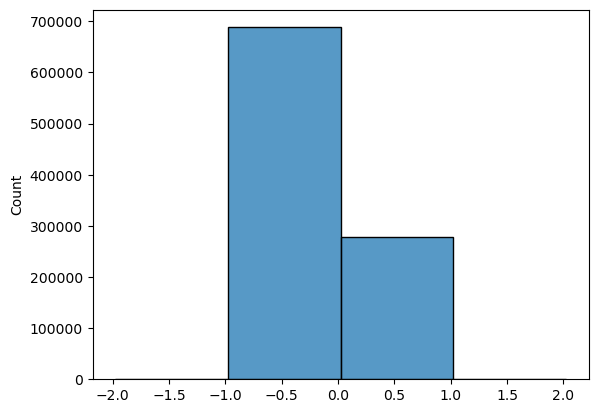

In [78]:
sns.histplot(y_preds, discrete=True)

<Axes: >

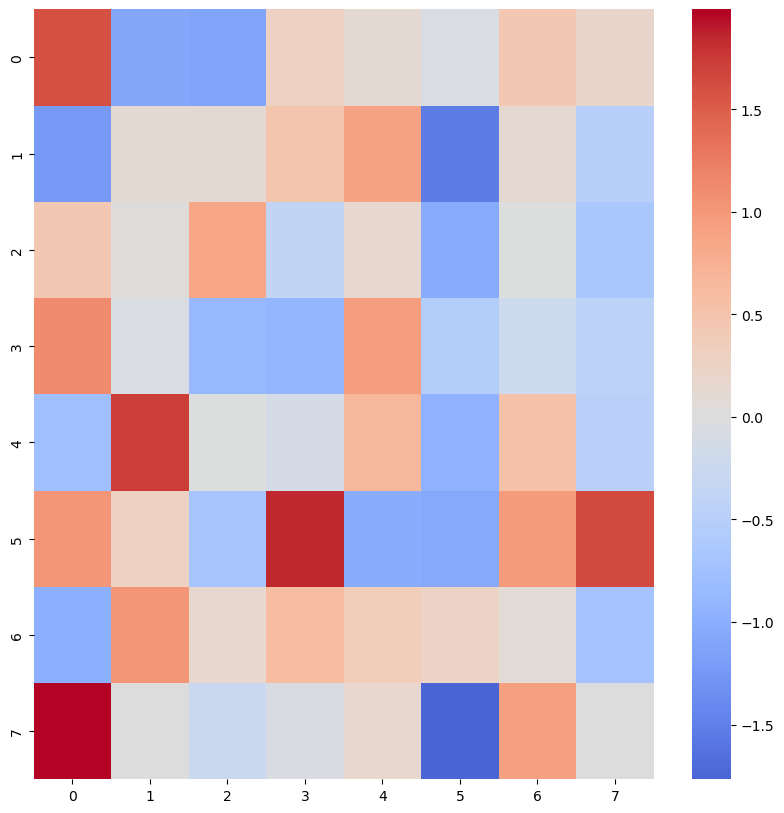

In [71]:
# Visualize the learned bilinear map
W = model.bilinear.W.detach().numpy()
plt.figure(figsize=(10, 10))
sns.heatmap(W, cmap="coolwarm", center=0)

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_score, KFold

In [19]:
model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=1000)
scores = cross_val_score(model, X, y, cv=KFold(5, shuffle=True), scoring="r2")

In [40]:
scores

array([0.05810032, 0.06242847, 0.06203571, 0.07060511, 0.06393827])

## Reduced regression analysis: cosine distance as metric

In [50]:
Xs, y = [], []
max_num_pairs, max_num_samples = 1000, 100

syllable_pairs = list(itertools.combinations(list(range(len(syllables))), 2))
np.random.shuffle(syllable_pairs)
syllable_pairs = syllable_pairs[:max_num_pairs]

for s1, s2 in tqdm(syllable_pairs):
    frame_pairs = list(itertools.product(list(range(len(final_frames[s1]))), list(range(len(final_frames[s2])))))
    np.random.shuffle(frame_pairs)
    frame_pairs = frame_pairs[:max_num_samples]
                       
    for f1, f2 in frame_pairs:
        Xs.append(distance.cosine(final_frames[s1][f1], final_frames[s2][f2]))
        y.append(distances[s1, s2])

X = np.stack(Xs)
y = np.array(y).astype(float)

X -= X.mean()
X /= X.std()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
model = RidgeCV(cv=KFold(5, shuffle=True))
scores = cross_val_score(model, X[:, None], y, cv=KFold(5, shuffle=True), scoring="r2")

In [52]:
scores

array([ 0.00044382, -0.00055969,  0.00010893,  0.00017792,  0.00025267])